# Visualising "closeness" of current members of parliament based on how they vote in divisions

We're going to use the similarity measure from They Vote For You on all current members of parliament and then use multi-dimensional scaling (MDS) to create a two dimensional "map" of all the members where their position on the map puts them close to other members who they voted similarly to and far away from those they voted very differently to.

One possible improvement for the future is to use the "strong" votes from policies to weight certain divisions more strongly than others in the calculation of similarity. Those would be divisions that related to actual concrete changes in the law (otherwise known as substantive changes).

We can't get the data we need directly through the They Vote For You API right now so we're going to get it by running some Ruby directly from the rails console. We'll document the steps here too.

Get all the distances between people who are current members
```
p = Member.current.where(house: "representatives").pluck(:person_id)
d = PeopleDistance.where(person1: p, person2: p).pluck(:person1_id, :person2_id, :distance_b)
File.open("distances.csv", "w") { |f| f.write(["person1_id", "person2_id", "distance_b"].to_csv); d.each {|l| f.write(l.to_csv)} }
```

We'll also need some information about each person so we can make things meaningful. We'll definitely need their name and party so let's start there
```
info = Member.current.where(house: "representatives").map{|m| [m.person.id, m.person.name, m.person.latest_member.party]}
File.open("people.csv", "w") { |f| f.write(["id", "name", "party"].to_csv); info.each {|l| f.write(l.to_csv)}}
```

Loading the exported csv...

In [1]:


distances = _deepnote_execute_sql("""SELECT *
FROM '/work/distances.csv' ORDER BY person1_id, person2_id;
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
distances

,person1_id,person2_id,distance_b
0,10007,10007,0.000000
1,10007,10014,0.996044
2,10007,10043,0.000000
3,10007,10060,0.000826
4,10007,10069,0.990121
...,...,...,...
22495,10963,10940,0.000000
22496,10963,10941,0.785124
22497,10963,10942,0.011152
22498,10963,10960,0.980843


In [2]:


people = _deepnote_execute_sql("""SELECT *
FROM '/work/people.csv' ORDER by id
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
people

,id,name,party
0,10007,Anthony Albanese,Australian Labor Party
1,10014,Kevin Andrews,Liberal Party
2,10043,Sharon Bird,Australian Labor Party
3,10060,Chris Bowen,Australian Labor Party
4,10069,Russell Broadbent,Liberal Party
...,...,...,...
145,10940,James Stevens,Liberal Party
146,10941,Zali Steggall,Independent
147,10942,Dave Sharma,Liberal Party
148,10960,Kristy McBain,Australian Labor Party


We need to turn this into a square matrix. We'll also need another array that converts between the index in the matrix and the `person_id`

In [3]:
dist_matrix = distances.pivot(index='person1_id', columns='person2_id', values='distance_b')
dist_matrix

person2_id,10007,10014,10043,10060,10069,10081,10086,10088,10123,10136,...,10935,10936,10937,10938,10939,10940,10941,10942,10960,10963
person1_id,,,,,,,,,,,,,,,,,,,,,
10007,0.000000,0.996044,0.000000,0.000826,0.990121,0.002070,0.000000,0.003288,0.000000,0.000000,...,0.994575,0.989673,0.983553,0.989492,0.998175,0.987719,0.282095,0.984429,0.000000,0.971292
10014,0.996044,0.000000,0.996231,0.994093,0.005240,0.992366,0.997079,0.991874,0.996991,0.995115,...,0.002028,0.001789,0.008696,0.001883,0.000000,0.001901,0.686792,0.007143,0.985019,0.004132
10043,0.000000,0.996231,0.000000,0.000814,0.991139,0.002030,0.000000,0.003065,0.000000,0.000000,...,0.990909,0.991304,0.993355,0.990876,0.994728,0.990893,0.348540,0.991349,0.000000,0.991667
10060,0.000826,0.994093,0.000814,0.000000,0.990529,0.001186,0.000448,0.001347,0.000467,0.000460,...,0.992063,0.987673,0.982558,0.987711,0.995106,0.985714,0.321375,0.983206,0.000000,0.970339
10069,0.990121,0.005240,0.991139,0.990529,0.000000,0.989243,0.995086,0.990934,0.994464,0.993637,...,0.001969,0.001869,0.009025,0.001805,0.000000,0.001942,0.684524,0.007421,0.987952,0.004202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10940,0.987719,0.001901,0.990893,0.985714,0.001942,0.977600,0.994774,0.987893,0.994434,0.991213,...,0.000000,0.000000,0.005997,0.000000,0.000000,0.000000,0.691935,0.004644,0.985507,0.000000
10941,0.282095,0.686792,0.348540,0.321375,0.684524,0.325265,0.334944,0.359223,0.329879,0.320205,...,0.693679,0.676145,0.686765,0.672414,0.672185,0.691935,0.000000,0.693374,0.246649,0.785124
10942,0.984429,0.007143,0.991349,0.983206,0.007421,0.975498,0.995033,0.982222,0.989565,0.986464,...,0.000000,0.004777,0.001437,0.004666,0.000000,0.004644,0.693374,0.000000,0.979112,0.011152


Now that we have a matrix of the distances we can plug that into the metric MDS algorithm to get the points transformed to a 2d plane.

In [4]:
from sklearn.manifold import MDS

mds = MDS(metric=True, dissimilarity='precomputed', random_state=0)
X_transform = mds.fit_transform(dist_matrix)
x = X_transform[:,0]
y = X_transform[:,1]
# Flip everything in the X direction just to not make this a left-right thing
x = list(map(lambda x: -x, x))

Now let's plot the result

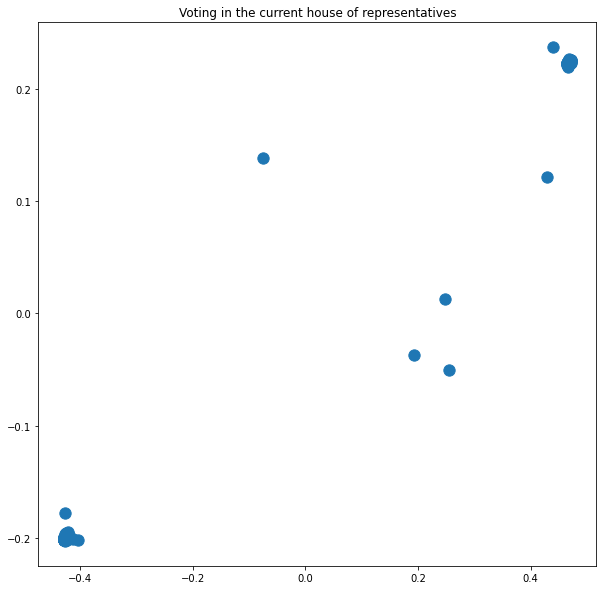

In [5]:
from matplotlib import pyplot as plt

fig = plt.figure(2, (10,10))
plt.scatter(x, y, s=128)
plt.title('Voting in the current house of representatives')
plt.show()

To make this more useful let's colour in each point with the colour of the party that the person is currently a member of. Let's start with some party colours (taken from https://en.wikipedia.org/wiki/Template:Australian_politics/party_colours)

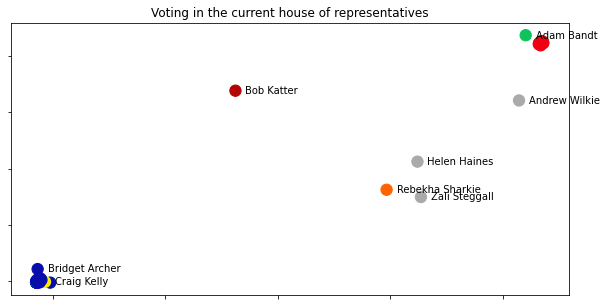

In [24]:
party_colours = {
    "Australian Labor Party": "#F00011",
    "Australian Greens": "#10C25B",
    # Deputy speaker. Hmmm...
    "CWM": "#0ee",
    "SPK": "#0ee",
    "Katter's Australian Party": "#B50204",
    "Centre Alliance": "#ff6300",
    "United Australia Party": "#FFED00",
    # TODO: What colour for the independents?
    "Independent": "#aaa",
    # For parties that are part of the coalition use the coalition colour
    "Liberal Party": "#080CAB",
    "National Party": "#080CAB",
    "Liberal National Party": "#080CAB",
}

def party_to_colour(party):
    return party_colours[party]

colours = list(map(party_to_colour, people["party"]))

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(10, 10))
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.scatter(x, y, c=colours, s=128)

# for i, txt in enumerate(people["name"]):
#     ax.annotate(txt, (x[i], y[i]), xytext=(10,-3), textcoords="offset pixels")

def label(name):
    i = list(people["name"]).index(name)
    ax.annotate(name, (x[i], y[i]), xytext=(10,-3), textcoords="offset pixels")

# Just label ones that are not just in a big clump
label("Adam Bandt")
label("Bob Katter")
label("Andrew Wilkie")
label("Helen Haines")
label("Rebekha Sharkie")
label("Zali Steggall")
label("Bridget Archer")
label("Craig Kelly")

plt.title('Voting in the current house of representatives')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [7]:
def plot_zoomed(x0, x1, y0, y1, title="Zoomed in area", show_ticks=False):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.xticks(visible=show_ticks)
    plt.yticks(visible=show_ticks)
    plt.scatter(x, y, c=colours, s=128)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)

    for i, txt in enumerate(people["name"]):
        ax.annotate(txt, (x[i], y[i]), xytext=(10,-3), textcoords="offset pixels")

    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

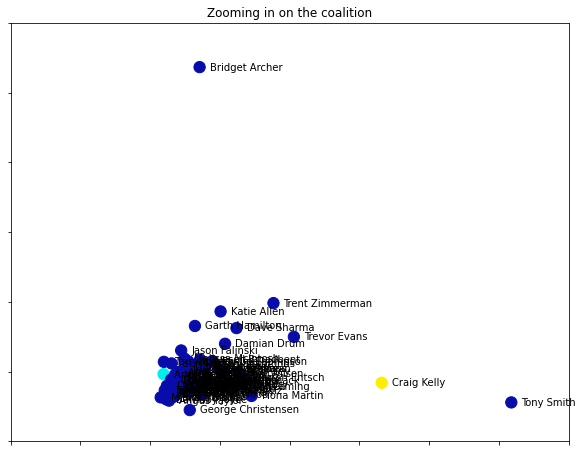

In [8]:
plot_zoomed(-0.44, -0.40, -0.205, -0.175, title="Zooming in on the coalition")

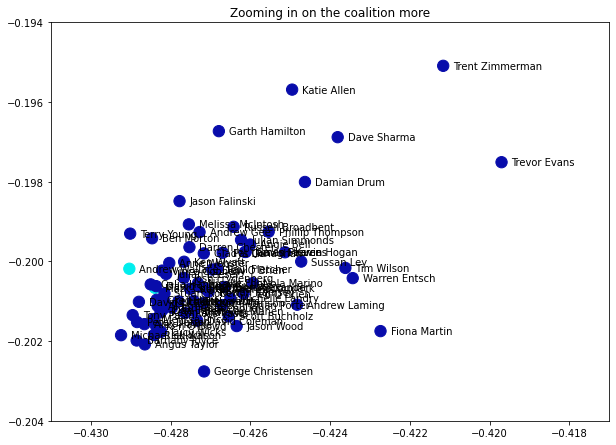

In [9]:
plot_zoomed(-0.431, -0.417, -0.204, -0.194, title="Zooming in on the coalition more", show_ticks=True)

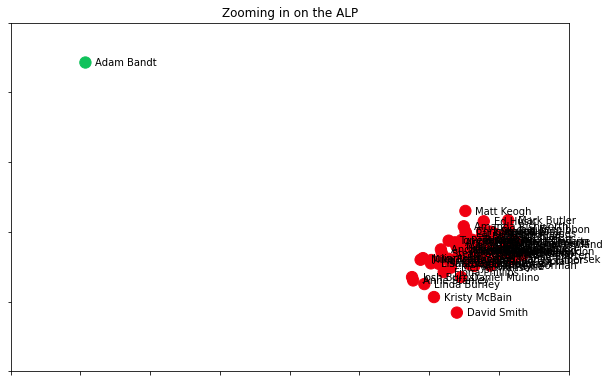

In [10]:
plot_zoomed(0.435, 0.475, 0.215, 0.24, title="Zooming in on the ALP")

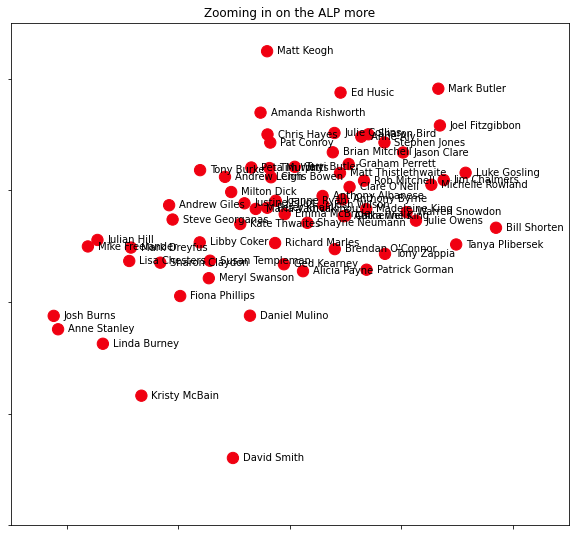

In [11]:
plot_zoomed(0.463, 0.473, 0.218, 0.227, title="Zooming in on the ALP more")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3cc29e64-76d4-4791-9f42-553d3a25e9a4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>